# 第19章 马尔可夫链蒙特卡罗法  之 采样算法

**马尔可夫链蒙特卡罗法**（Markov Chain Monte Carlo, MCMC）是以马尔可夫链为概率模型的蒙特卡罗法。
在了解MCMC方法之前，需要了解一下**蒙特卡罗法**及其常见的几种采样方法。

**蒙特卡罗法** 是通过从概率模型的随机采样进行近似数值计算的方法。
采样算法的目的就是**从给定的分布中生成随机样本**。
这里介绍几种简单的采样方法，包括从**标准分布采样**、**接受-拒绝采样**、**重要性采样**、**SIR采样**。
在介绍了传统的采样方法之后，将介绍传统算法的缺陷，从而引出MCMC方法的优越性。

这一部分主要是为了增加对采样方法的理解，接受-拒绝采样部分使用了李航老师的资料，其他部分采用了PRML中的介绍。

    蒙特卡罗法    
        1. 标准分布采样
        2. 接受拒绝采样
        3. 重要性采样
        4. SIR采样
        
    蒙特卡罗法的应用
    
参考资料
https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98

https://github.com/WillKoehrsen/ai-projects/blob/master/markov_chain_monte_carlo/markov_chain_monte_carlo.ipynb

https://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf

https://github.com/ctgk/PRML/blob/master/notebooks/ch11_Sampling_Methods.ipynb


In [1]:
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

%matplotlib inline
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. 蒙特卡罗法    

统计学和机器学习的目的是基于数据对概率分布的特征进行推断，蒙特卡罗法要解决的问题是，假设概率分布的定义己知，通过抽样获得概率分布的随机样本，并通过得到的随机样本对概率分布的特征进行分析。
比如，从样本得到经验分布，从而估计总体分布；或者从样本汁算出样本均值，从而估计总体期望。
所以蒙特卡罗法的核心是随机抽样（random sampling) 。

一般的蒙特卡洛法有直接抽样法、接受-拒绝抽样法、重要性抽样法等。
接受-拒绝抽样法、重要性抽样法适合于概率密度函数复杂（如密度函数含有多个变量，各变量相互不独立，密度函数形式复杂），不能直接抽样的情况。

###  1.1 直接采样法

从标准分布中直接采样是最简单、最理想的一种采样方法。
我们仅仅需要一个介于$(0,1)$的均匀分布生成器就可以开始工作了。

In [2]:
np.random.uniform(0,1)

0.6695818348686509

假设变量$z$服从$(0,1)$均匀分布，那么我们可以用某个函数$f(\cdot)$把$z$转化成变量$y$。
如果变量$y$的形式是$y=f(z)$，那么$y$的概率分布函数如下

$$ p(y) = p(z) \left| \frac{dz}{dy} \right| $$

对概率密度函数进行积分后，就得到了累计分布函数

$$ z = h(y) = \int_{-\infty}^{y} p(y)dy$$

找到 $h(\cdot)$ ，把变量 $y$ 写成 $y=h^{-1}(z)$ 的形式，这样就可以用均匀分布 $z$ 实现标准分布的直接采样。

#### 案例一 指数分布

指数分布的概率密度函数是 $p(y)=\lambda \exp(-\lambda y)$，对概率密度函数积分可以得到累计分布函数 

$$z=h(y)=1-\exp(-\lambda y)$$

把 $y$ 写成 $z$ 的函数，则有 

$$y = -\lambda^{-1} \ln(1-z)$$

In [3]:
def exp_dist(x, _lambda=0.1):
    return _lambda * np.exp(-_lambda * x)

def invert_exp_pdf(x, _lambda=0.1):
    return - (1/_lambda) * np.log(1-x)

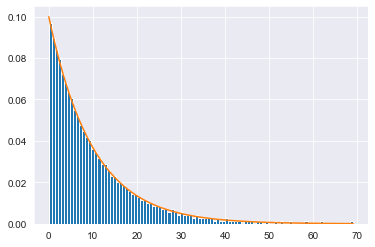

In [36]:
x_list = np.linspace(0, 1, 1000, endpoint=False)[1:]
samples = invert_exp_pdf(x_list)
n, bins, patches = plt.hist(samples, bins=100, density=True,label='sampling')

y = exp_dist(bins)
plt.plot(bins, y,label='f(x)')

plt.show()

### 1.2 接受-拒绝抽样法


上面介绍的直接采样算法需要先计算累计分布函数的反函数。
也就是说，当我们无法得到某个分布的累计分布反函数时，我们就无法直接采样。

**接受-拒绝抽样法**（accept-reject sampling method）的思想是通过容易采样的分布来计算比较难以采样的分布。

找一个可以直接抽样的分布，称为建议分布（proposal distribution) ，常见的辅助分布包括**均匀分布**或者**正态分布**等。
假设 $q(z)$ 是建议分布的概率密度函数，并且可以保证 $q(z)$ 的 $c$ 倍一定大于等于$p(z)$，其中$c>0$。
常数$c$的值越小越好，理想情况下是$1$。

现在进行两次采样——
首先从$q(z)$中采样得到样本$z$，
随后从$(0,1)$均匀分布中采样得到样本$u$。
此时，如果 $ u \leq \frac{p(z)}{cq(z)}$，那么就接受样本$z$。

#### 接受-拒绝抽样法流程

输入：抽样的目标概率分布的概率密度函数 $p(z)$；

输出：概率分布的随机样本$x_1, x_2, \cdots, x_n$。

参数：样本数 $n$

* 1. 选择建议分布为$q(x)$。
* 2. 按照建议分布$q(x)$随机抽样得到样本$z$
* 3. 按照均匀分布在$(0,1)$范围内抽样得到$u$
* 4. 如果$u \leq \frac{p(z)}{cq(z)}$，则将$z$作为抽样结果；否则，回到步骤$2$。
* 5. 直至得到$n$个随机样本，结束。

In [70]:
def rejection_sampling(_target_func, _propose_func, c, num):
    """
    perform rejection sampling n times
    
    Parameters
    ----------
    _target_func : callable
        (un)normalized distribution to be sampled from
    _propose_func : RandomVariable
        distribution to generate sample
    c : float
        constant to be multiplied with the distribution
    n : int
        number of samples to draw
    Returns
    -------
    sample : (n, ndim) ndarray
        generated sample
    """

    sample = []
    sample_num = 0
    trial_num = 0

    # 得到 $n$ 个随机样本
    while True:
        # 按照建议分布 $q(x)$ 随机抽样得到样本 $z$ 
        z = _propose_func.rvs()
        
        # 按照均匀分布在$(0,1)$范围内抽样得到 $u$
        u = np.random.uniform(0, 1)
        
        # 如果$u < \frac{p(z)}{cq(z)}$，则将 $z$ 作为抽样结果；否则，回到步骤$2$。
        p_z = _target_func(z)
        q_z = _propose_func.pdf(z)
        if u <= p_z / (c * q_z):
            sample.append(z)
            sample_num += 1
        trial_num += 1
        if sample_num > num:
            return sample, (sample_num / trial_num)

In [73]:
def plot_reject_sampling(_target, _propose, c=15, num=5000):
    
    samples, trial_rate = rejection_sampling(_target, _propose, c, num)
    print(f"采样效率（样本数量/采样次数）= {trial_rate * 100: 2.2f}%")

    fig = plt.figure()

    # 绘制 接受-拒绝采样法 得到的样本点
    ax1 = fig.add_subplot(111)
    _, bins, _ = plt.hist(samples, bins=100, label='sampling', color="blue")
    ax1.set_ylabel('hist')
    ax1.set_title("Rejection sampling")

    # 绘制 目标分布 和 建议分布
    ax2 = ax1.twinx()
    plt.plot(bins, target(bins))
    plt.plot(bins, c * propose.pdf(bins), label=r"$kq(z)$")
    ax2.set_ylabel('prob')

    plt.show()

#### 案例二

以正态分布作为建议分布，用接受-拒绝采样法进行采样。
下图中的橙色曲线代表建议分布，蓝色曲线代表要进行采样的复杂分布，直方图代表接受-拒绝采样法得到的样本点。

采样效率（样本数量/采样次数）=  47.42%


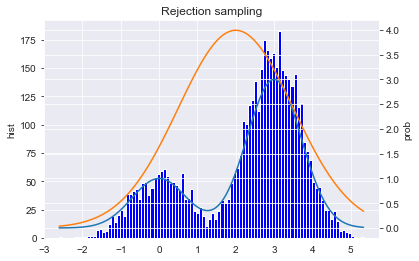

In [74]:
def target(x):
    return np.exp(-x ** 2) + 3 * np.exp(-(x - 3) ** 2)

propose = stats.norm(loc=np.array([2.]), scale=np.array([1.5]))

plot_reject_sampling(target, propose, c=15, num=5000)

#### 案例三

以均匀分布作为建议分布，用接受-拒绝采样法进行采样。
下图中的橙色曲线代表建议分布，蓝色曲线代表要进行采样的复杂分布，直方图代表接受-拒绝采样法得到的样本点。

采样效率（样本数量/采样次数）=  29.90%


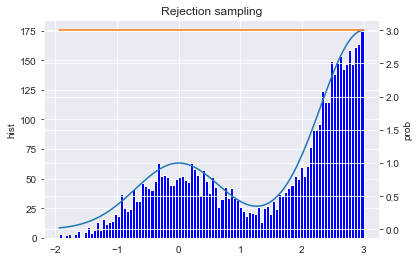

In [75]:
def target(x):
    return np.exp(-x ** 2) + 3 * np.exp(-(x - 3) ** 2)

propose = stats.uniform(-2, 5)

plot_reject_sampling(target, propose, c=15, num=5000)

接受-拒绝法的优点是容易实现，缺点是效率可能不高。
如果 $p(x)$ 的涵盖体积占 $cq(x)$ 的涵盖体积的比例很低，就会导致拒绝的比例很高，抽样效率很低。
注意，一般是在高维空间进行抽样，即使$p(x)$与$cq(a)$很接近，两者涵盖体积的差异也可能很大。

以上面的两个案例来说，因为正态分布和目标分布比较相似，所以以正态分布作为建议分布的采样效率达到 47.42%；相比之下，均匀分布作为建议分布的采样效率仅仅为 29.90%。

### 1.3 重要性采样



